# Libraries

In [2]:
%pylab inline
import Tools.ext as Te
import Tools.display as Td
import Tools.matrices as Tm
import Tools.functions as Tf
import Connectomes_Jonathan as Cj
import pandas as pd
from IPython.display import HTML
from scipy.stats import ranksums

Populating the interactive namespace from numpy and matplotlib


# Loading

In [3]:
dir_86 = '../../../TimeCourses/Jonathan/86/'
dir_512 = '../../../TimeCourses/Jonathan/512/'
dir_nEEG = '../../../TimeCourses/Jonathan/86_noEEG/'
Reg0 = 'grey_matter_sansSB_sansLCR/'
Reg1 = 'grey_matter_sansSB_sansLCR_sansGlobMean/'

In [3]:
KS1 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_86 + Reg0)])
KS2 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_nEEG + Reg0)])

In [4]:
TC = {'86u':{},'86r':{},'512u':{},'512r':{},'nEu':{},'nEr':{}}
for typ, di, sub in [['86u',  dir_86,   Reg0], ['86r',  dir_86,   Reg1],
                     ['512u', dir_512,  Reg0], ['512r', dir_512,  Reg1],
                     ['nEu',  dir_nEEG, Reg0], ['nEr',  dir_nEEG, Reg1]]:
    if 'nE' in typ: K = KS2
    else:           K = KS1
    for k in K:
        TC[typ][k] = Te.data2array(di + sub + k + '.txt', finite=True).T

# Dynamical Functional Connectivity

In [4]:
try:    DFC
except: DFC={}
for w in [5,10,15,30]:
    DFC[str(w)] = {'86u':{},'86r':{},'512u':{},'512r':{},'nEu':{},'nEr':{}}
    for typ in DFC[str(w)].keys():
        if 'nE' in typ: K = KS2
        else:           K = KS1
        for k in K:
            try: 
                DFC[str(w)][typ][k] = Te.data2array('./DFC/Reg_%s_win_%i_%s.npy'%(typ,w,k))
            except: 
                print typ, k
                FCs = Tf.windowedFCs(TC[typ][k].T, window=w)
                DFC[str(w)][typ][k] = Tf.windowedCorrelations(FCs)
                Te.array2data(DFC[str(w)][typ][k], './DFC/Reg_%s_win_%i_%s.npy'%(typ,w,k))

# DFC Analysis

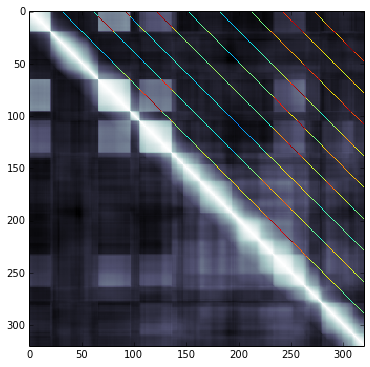

In [187]:
a = DFC['30']['512r']['t10']
fig = figure(figsize(6,6))
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet')
cmap.set_under('g', 0.001)
ax.imshow(a, interpolation='nearest', cmap='bone')
for i in range(1,10):
    ax.imshow(diag(diag(a, k=30*i), k=30*i), interpolation='nearest', cmap=cmap, vmin=0.001);

115600 330


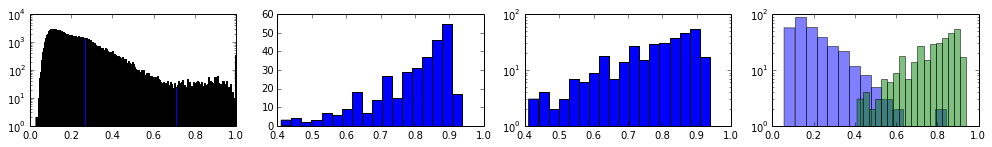

In [70]:
w, typ, k = 10, '512r', 't13'
a = DFC[str(w)][typ][k].flatten()
b = 1.- diag(DFC[str(w)][typ][k], k=w)
c = a[permutation(range(len(a)))[:len(b)]]
print len(a), len(b)
figure(figsize=(17,2))
subplot(141);p=hist(a, bins=Td.nbChiHist(a));  yscale('log', nonposy='clip'); 
subplot(142);  hist(b, Td.nbChiHist(b))
subplot(143);p=hist(b, bins=Td.nbChiHist(b));yscale('log', nonposy='clip');# xlim(p[1].min(), p[1].max());
subplot(144)
p=hist(c, bins=Td.nbChiHist(c), alpha=.5);  yscale('log', nonposy='clip')
q=hist(b, bins=Td.nbChiHist(b), alpha=.5); yscale('log', nonposy='clip'); 

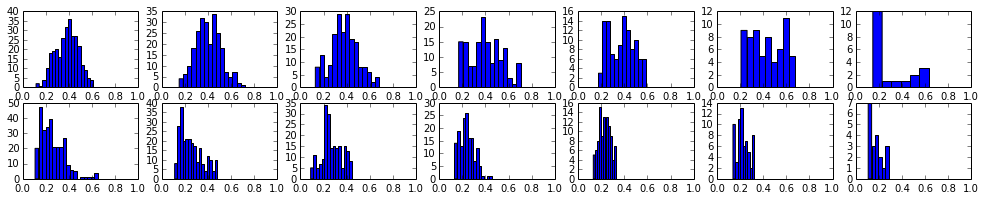

In [212]:
w, k = 15, 'p06'
figure(figsize=(17,3))
for i in range(14):
    if i <7: b = diag(DFC[str(w)]['512u'][k], k=(i+1)*3*w)
    else:    b = diag(DFC[str(w)]['512r'][k], k=(i-7+1)*3*w)
    subplot(2,7,i+1)
    p = hist(b, bins=Td.nbChiHist(b)); xlim(0,1)

## Valeurs aux Maximums et Déviations Standards

In [4]:
maxs = Te.data2array('./DFC/maxs.npy', dic=1)
devs = Te.data2array('./DFC/devs.npy', dic=1)
meds = Te.data2array('./DFC/meds.npy', dic=1)

In [42]:
del maxs, devs, meds

In [50]:
for w in ['5','10','15','30']:
    for typ in ['512r','512u','86r','86u']:
        try:  
            maxs['p'][w][typ][str(int(w)*4)]
            continue
        except:
            try:
                maxs['p'][w][typ], maxs['t'][w][typ] = {}, {}
                devs['p'][w][typ], devs['t'][w][typ] = {}, {}
                meds['p'][w][typ], meds['t'][w][typ] = {}, {}
            except:
                try:
                    maxs['p'][w], maxs['t'][w] = {typ:{}}, {typ:{}}
                    devs['p'][w], devs['t'][w] = {typ:{}}, {typ:{}}
                    meds['p'][w], meds['t'][w] = {typ:{}}, {typ:{}}
                except:
                    maxs = {'p':{w:{typ:{}}}, 't':{w:{typ:{}}}}
                    devs = {'p':{w:{typ:{}}}, 't':{w:{typ:{}}}}
                    meds = {'p':{w:{typ:{}}}, 't':{w:{typ:{}}}}
                    
        DDD = DFC[w][typ]
        for i in range(100):
                for k in sorted(DDD.keys()):
                    dists = 1.- diag(DDD[k], k=(i+1)*int(w))
                    if len(dists) > 3:
                        h1, b1 = histogram(dists, bins=2*Td.nbChiHist(dists))
                        h2, b2 = histogram(dists, bins=sqrt(len(dists)))
                        h3, b3 = histogram(dists, bins=ceil(log2(len(dists))+1))
                        h, b = [[h1,b1], [h2,b2], [h3,b3]][argmax([h1.max(), h2.max(), h3.max()])]
                        
                        try:    maxs[k[0]][w][typ][str((i+1)*int(w)*4)].append( b[h.argmax()] )
                        except: maxs[k[0]][w][typ][str((i+1)*int(w)*4)] = []
                        try:    devs[k[0]][w][typ][str((i+1)*int(w)*4)].append( std(dists) )
                        except: devs[k[0]][w][typ][str((i+1)*int(w)*4)] = []
                        try:    meds[k[0]][w][typ][str((i+1)*int(w)*4)].append( median(dists) )
                        except: meds[k[0]][w][typ][str((i+1)*int(w)*4)] = []

In [22]:
def table(maxs):
    import pandas as pd
    d1,d2,d3,d4,val = [],[],[],[],[]
    tt, pp = maxs['t'], maxs['p']
    
    for w in sorted(tt.keys()):
        for typ in sorted(tt[w].keys()):
            for jp in sorted(tt[w][typ].keys()):
                d1.append(float(w)*4)
                d2.append(typ[:-1])
                d3.append((typ[-1] == 'u') * 'NoReg' + (typ[-1] == 'r') * 'Reg')
                d4.append('%5.2f'%(float(jp)/60))
                val.append( 100 * ranksums(tt[w][typ][jp], pp[w][typ][jp])[1]
                            * (-1) ** (mean(tt[w][typ][jp]) > mean(pp[w][typ][jp])) )
                    
    return pd.DataFrame({'window (s)':d1, '# nodes':d2, 'Gbl mean':d3, 'Jump (min)':d4, 'val':val})

In [26]:
X = table(maxs)
D = table(devs)
M = table(meds)

In [19]:
alljps, twmjps = ['%5.2f'%i for i in arange(1/3.,23,1/3.)], ['%5.2f'%i for i in arange(2.00,21,2)]
jps = setdiff1d(alljps, twmjps)

In [27]:
dX = Td.tableShow(X, ind=['window (s)','Gbl mean','Jump (min)'], uns=['Gbl mean','window (s)'], spe={'# nodes':['512']}, nspe={'Jump (min)':jps}, 
             cmap=Td.speCmap('coolwarm_r', r=(0,1)), sort=1, nan='', maxs=[-50,50], fmt='%i', justDF=1)
dD = Td.tableShow(D, ind=['window (s)','Gbl mean','Jump (min)'], uns=['Gbl mean','window (s)'], spe={'# nodes':['512']}, nspe={'Jump (min)':jps}, 
             cmap=Td.speCmap('coolwarm_r', r=(0,1)), sort=1, nan='', maxs=[-50,50], fmt='%i', justDF=1)
dM = Td.tableShow(M, ind=['window (s)','Gbl mean','Jump (min)'], uns=['Gbl mean','window (s)'], spe={'# nodes':['512']}, nspe={'Jump (min)':jps}, 
             cmap=Td.speCmap('coolwarm_r', r=(0,1)), sort=1, nan='', maxs=[-50,50], fmt='%i', justDF=1)
S = pd.concat([dM,dE,dD], axis=1, join='outer', keys=['"Distances at Max"','"Medians"','"Deviations"'], names=['p-val (%)'])

In [25]:
HTML(S.to_html(escape=False))

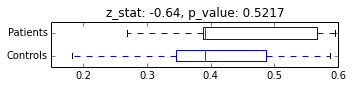

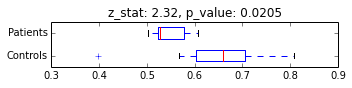

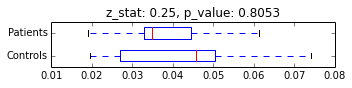

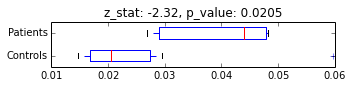

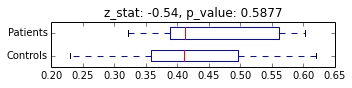

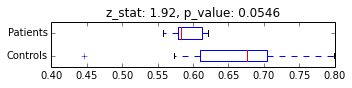

In [28]:
for dico, w, typ, jp in [[maxs, 30, '512u', '1200'],[maxs, 30, '512r', '1200'],
                         [devs, 30, '512u', '1200'],[devs, 30, '512r', '1200'],
                         [meds, 30, '512u', '1200'],[meds, 30, '512r', '1200']]:
    pp, tt = dico['p'][str(w)][typ][jp], dico['t'][str(w)][typ][jp]
    fig = figure(figsize=(5, 1.3)); ax = fig.add_subplot(111)
    _= ax.boxplot([tt, pp], vert=0, widths=.5);
    ax.set_yticklabels(['Controls','Patients']);
    ax.set_title('z_stat: %.2f, p_value: %.4f'% ranksums(tt, pp))
    tight_layout()

In [ ]:
for dico, w, typ, jp in [[devs, 5, '512r', k] for k in devs['p']['5']['512r'].keys()]:
    pp, tt = dico['p'][str(w)][typ][jp], dico['t'][str(w)][typ][jp]
    fig = figure(figsize=(5, 1.)); ax = fig.add_subplot(111)
    _= ax.boxplot([tt, pp], vert=0, widths=.5);
    ax.set_yticklabels(['Controls','Patients']);
    ax.set_title('z_stat: %.2f, p_value: %.4f'% ranksums(tt, pp))
    tight_layout()